
# Analysis of UK Electricity Demand

Quick Analysis of UK energy demand data
Sections
- descriptive stats (mean, variance, percentiles),
- seasonality (daily / weekly / annual),
- rolling behaviour (trend & volatility),
- anomaly detection (rolling z-scores),
- hypothesis testing (weekday vs weekend, seasonal differences),
- (optional) seasonal decomposition,





## Imports & configuration

In [16]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, spearmanr

# Optional: seasonal decomposition (if installed)
try:
    from statsmodels.tsa.seasonal import seasonal_decompose
    HAS_STATSMODELS = True
except Exception:
    HAS_STATSMODELS = False
    print("statsmodels not found — seasonal decomposition cells will be skipped.")

# Matplotlib defaults (no explicit styles/colors per project guidelines)
plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["axes.grid"] = True

# Paths — update if your repo uses different locations
PATH_WIDE = "data/processed/tables/demand_wide.parquet"   # has columns: startTime, actual, forecast



## Load demand data

We try to load the **wide demand table** with `actual` and `forecast`.  
If it's not present, we load the **combined** long format and pivot.


In [17]:

from pathlib import Path
import os
os.chdir(r"C:/Users/jakel/Documents/PythonProjects/UKPowerProject")

def load_demand_wide(path_wide=PATH_WIDE):
    if Path(path_wide).exists():
        df = pd.read_parquet(path_wide)
        # Basic expectations
        assert {"startTime","actual","forecast"}.issubset(df.columns), "Expected columns missing in demand_wide."
        df["startTime"] = pd.to_datetime(df["startTime"], utc=True, errors="coerce")
        return df.sort_values("startTime").reset_index(drop=True)
    else:
        raise FileNotFoundError("Could not find demand_wide or combined parquet. Update PATH_WIDE.")

df = load_demand_wide()
df.head()


,startTime,actual,forecast
0,2023-11-11 00:00:00+00:00,26199.0,24520.0
1,2023-11-11 00:30:00+00:00,26214.0,24500.0
2,2023-11-11 01:00:00+00:00,26019.0,23984.0
3,2023-11-11 01:30:00+00:00,25571.0,23416.0
4,2023-11-11 02:00:00+00:00,25274.0,22957.0



## Descriptive statistics (actual demand)

Quick magnitudes & spread: mean, std, min, max, and percentiles.


In [18]:
import pandas as pd
import numpy as np

PCTS = [0.05, 0.25, 0.50, 0.75, 0.95]

desc_actual = df["actual"].describe(percentiles=PCTS).to_frame("actual")
desc_forecast = df["forecast"].describe(percentiles=PCTS).to_frame("forecast")

summary = desc_actual.join(desc_forecast)


summary["Δ (forecast-actual)"] = summary["forecast"] - summary["actual"]

def safe_rel_delta(row):
    a = row["actual"]
    f = row["forecast"]
    return np.nan if a == 0 else (f - a) / a * 100.0

summary["Δ% vs actual"] = summary.apply(safe_rel_delta, axis=1)

summary = summary.round({
    "actual": 1, "forecast": 1,
    "Δ (forecast-actual)": 1,
    "Δ% vs actual": 2
})

ROW_ORDER = ["count","mean","std","min","5%","25%","50%","75%","95%","max"]
summary = summary.reindex(ROW_ORDER)

summary


,actual,forecast,Δ (forecast-actual),Δ% vs actual
count,35055.0,33936.0,-1119.0,-3.19
mean,28326.7,26155.8,-2170.9,-7.66
std,5824.3,6071.6,247.3,4.25
min,15299.0,14000.0,-1299.0,-8.49
5%,20723.4,18073.0,-2650.4,-12.79
25%,23878.0,21417.0,-2461.0,-10.31
50%,27130.0,25103.0,-2027.0,-7.47
75%,31855.0,29941.2,-1913.8,-6.01
95%,39819.3,37946.2,-1873.0,-4.70
max,47599.0,45600.0,-1999.0,-4.20


From this, it would seem the forecast underpredicts demand. 
More significantly it underestimates the actual demand when it comes to periods of low demand.

Some correction here would be suitable

The forecast is also more volatile.
Would be useful to find where it is over exagerating volatility.


## Daily seasonality — Hour-of-day profile

Expectation (GB): **morning ramp** and **evening peak** (around 17:00–19:00 local; data are in UTC).


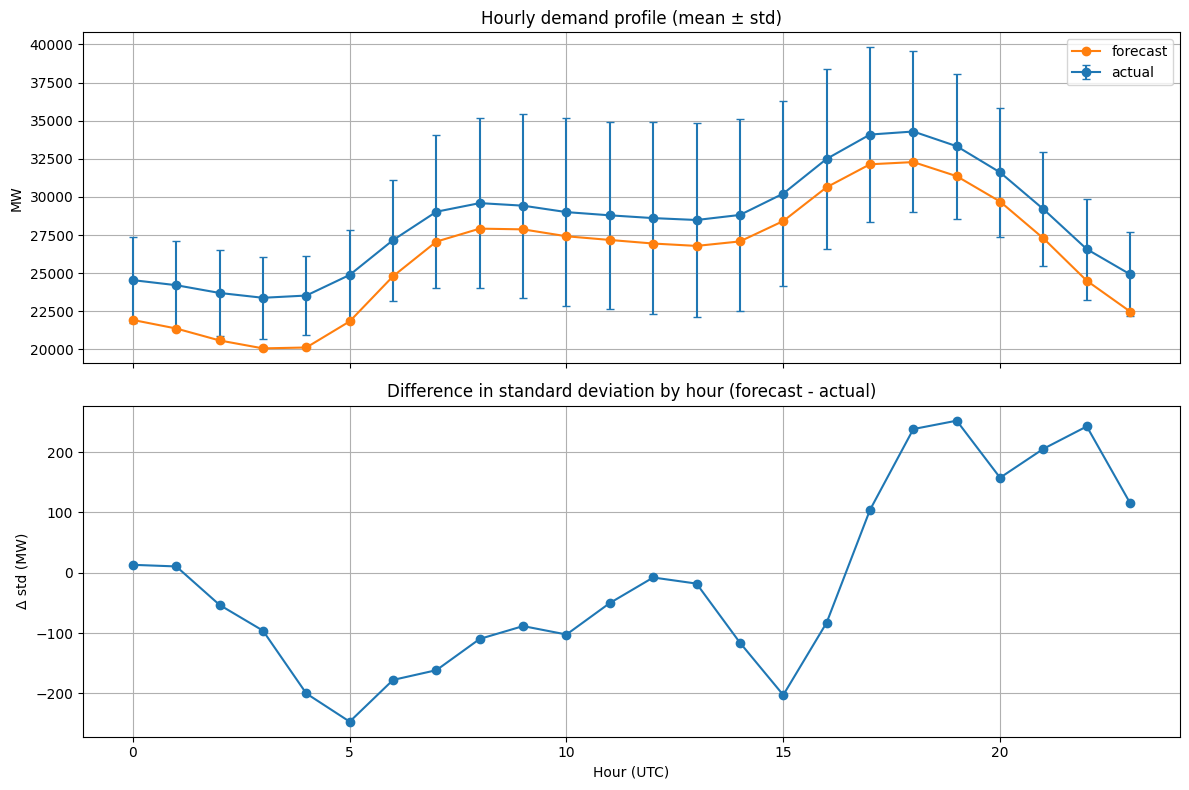

In [25]:
import numpy as np
import matplotlib.pyplot as plt

df["hour"] = df["startTime"].dt.hour

hourly_actual = df.groupby("hour")["actual"].agg(["mean","std"])
hourly_forecast = df.groupby("hour")["forecast"].agg(["mean"])

actual_std  = df.groupby("hour")["actual"].std()
fc_std      = df.groupby("hour")["forecast"].std()

std_diff = fc_std - actual_std   # positive = forecast more volatile




fig, axs = plt.subplots(2,1,sharex=True,figsize=(12,8))

# ───────────────────────── TOP: mean ± std
axs[0].errorbar(hourly_actual.index, hourly_actual["mean"],
                yerr=hourly_actual["std"], fmt="-o", capsize=3, label="actual")
axs[0].plot(hourly_forecast.index, hourly_forecast["mean"], "-o", label="forecast")

axs[0].set_title("Hourly demand profile (mean ± std)")
axs[0].set_ylabel("MW")
axs[0].legend()

# ───────────────────────── BOTTOM: residual size by hour
axs[1].plot(std_diff.index, std_diff.values, "-o")
axs[1].set_title("Difference in standard deviation by hour (forecast - actual)")
axs[1].set_xlabel("Hour (UTC)")
axs[1].set_ylabel("Δ std (MW)")

plt.tight_layout()
plt.show()


Plots as expected
Not much difference in the std, maybe the forcast is more volatile in winter


# Weekly seasonality


0=Monday … 6=Sunday.


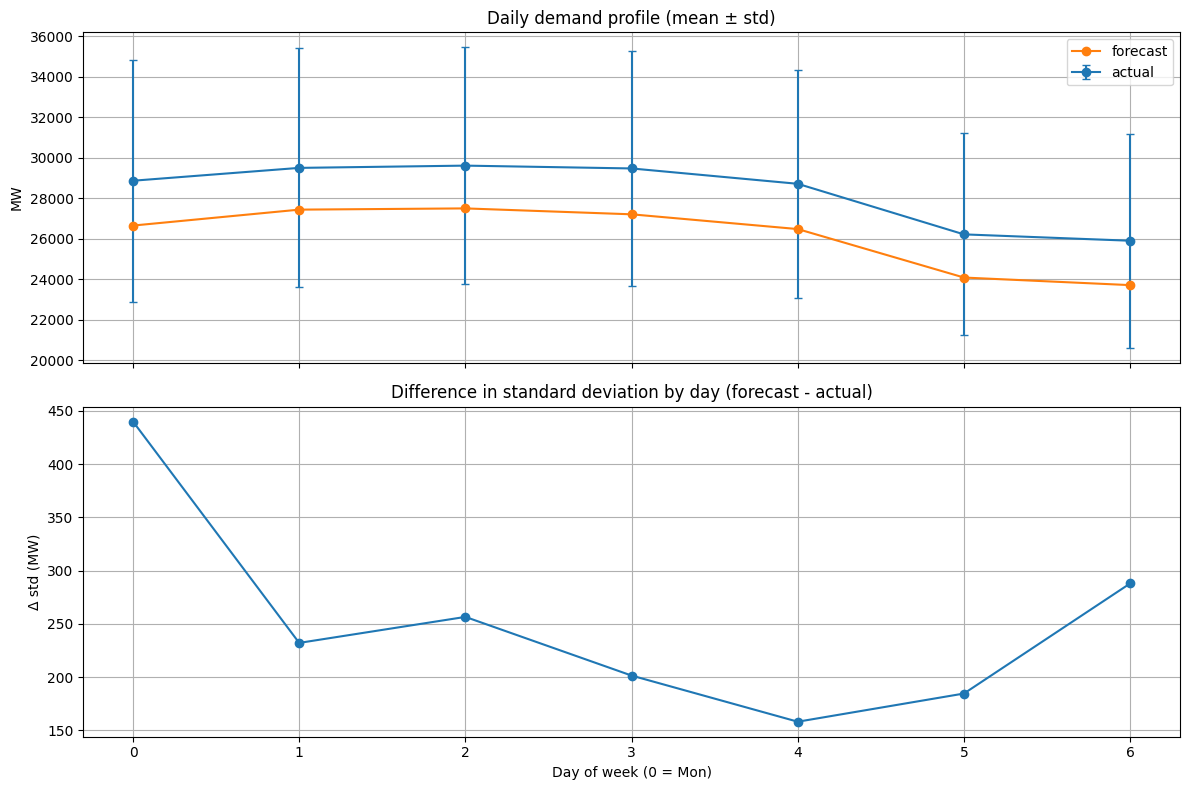

In [11]:
import numpy as np
import matplotlib.pyplot as plt

df["dow"] = df["startTime"].dt.dayofweek

actual = df.groupby("dow")["actual"].agg(["mean","std"])
forecast = df.groupby("dow")["forecast"].agg(["mean"])

actual_std  = df.groupby("dow")["actual"].std()
fc_std      = df.groupby("dow")["forecast"].std()

std_diff = fc_std - actual_std   # positive = forecast more volatile




fig, axs = plt.subplots(2,1,sharex=True,figsize=(12,8))

# ───────────────────────── TOP: mean ± std
axs[0].errorbar(actual.index, actual["mean"],
                yerr=actual["std"], fmt="-o", capsize=3, label="actual")
axs[0].plot(forecast.index, forecast["mean"], "-o", label="forecast")

axs[0].set_title("Daily demand profile (mean ± std)")
axs[0].set_ylabel("MW")
axs[0].legend()

# ───────────────────────── BOTTOM: residual size by day
axs[1].plot(std_diff.index, std_diff.values, "-o")
axs[1].set_title("Difference in standard deviation by day (forecast - actual)")
axs[1].set_xlabel("Day of week (0 = Mon)")
axs[1].set_ylabel("Δ std (MW)")

plt.tight_layout()
plt.show()


Shape as expected with less demand on weekends
It does seem like StD diff peaks at the week start 


#  Monthly profile



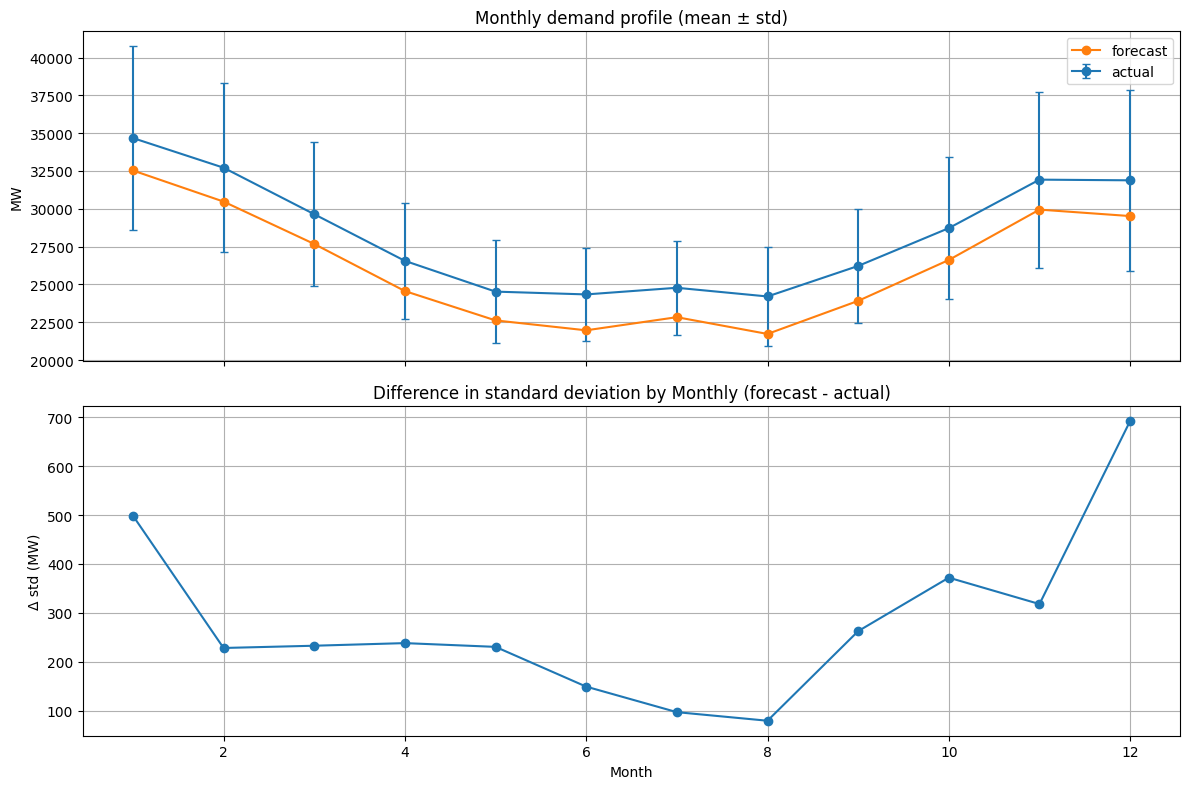

In [31]:

import numpy as np
import matplotlib.pyplot as plt

df["month"] = df["startTime"].dt.month

actual = df.groupby("month")["actual"].agg(["mean","std"])
forecast = df.groupby("month")["forecast"].agg(["mean"])

actual_std  = df.groupby("month")["actual"].std()
fc_std      = df.groupby("month")["forecast"].std()

std_diff = fc_std - actual_std   # positive = forecast more volatile




fig, axs = plt.subplots(2,1,sharex=True,figsize=(12,8))

# ───────────────────────── TOP: mean ± std
axs[0].errorbar(actual.index, actual["mean"],
                yerr=actual["std"], fmt="-o", capsize=3, label="actual")
axs[0].plot(forecast.index, forecast["mean"], "-o", label="forecast")

axs[0].set_title("Monthly demand profile (mean ± std)")
axs[0].set_ylabel("MW")
axs[0].legend()

# ───────────────────────── BOTTOM: residual size by day
axs[1].plot(std_diff.index, std_diff.values, "-o")
axs[1].set_title("Difference in standard deviation by Monthly (forecast - actual)")
axs[1].set_xlabel("Month")
axs[1].set_ylabel("Δ std (MW)")

plt.tight_layout()
plt.show()



Higher in winter than summer as expected.
Higher volatility over estimate in winter


## Rolling behaviour — Trend & Volatility

- **Rolling mean (7 days)** reveals slow-moving trend.
- **Rolling std (7 days)** reveals **volatility clustering** (often higher in winter).


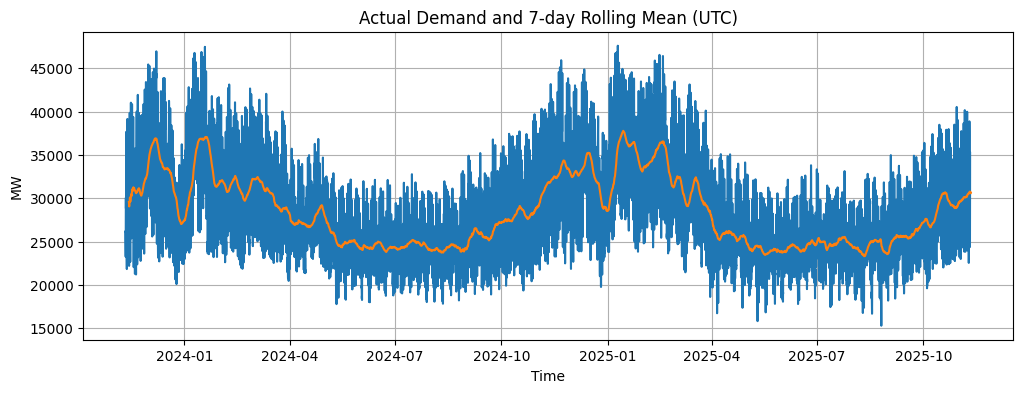

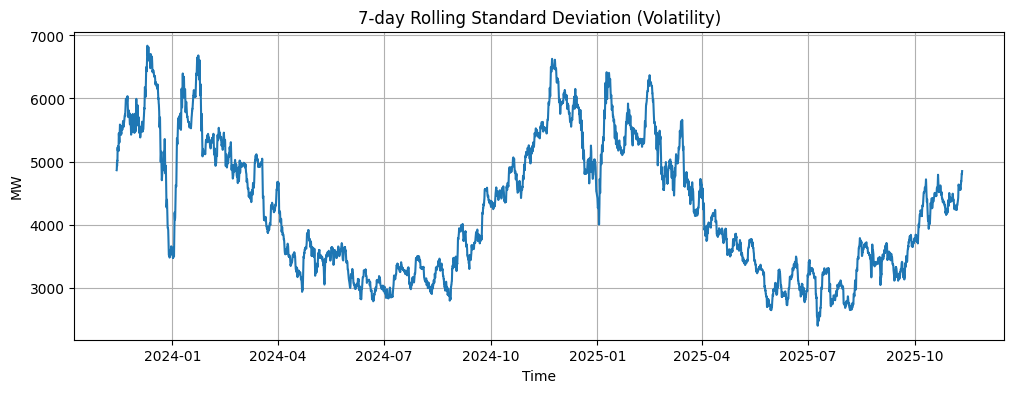

In [6]:

df = df.sort_values("startTime").reset_index(drop=True)
df["roll_mean_7d"] = df["actual"].rolling(48*7, min_periods=48*3).mean()
df["roll_std_7d"]  = df["actual"].rolling(48*7, min_periods=48*3).std()

plt.figure()
plt.plot(df["startTime"], df["actual"])
plt.plot(df["startTime"], df["roll_mean_7d"])
plt.title("Actual Demand and 7-day Rolling Mean (UTC)")
plt.xlabel("Time")
plt.ylabel("MW")
plt.show()

plt.figure()
plt.plot(df["startTime"], df["roll_std_7d"])
plt.title("7-day Rolling Standard Deviation (Volatility)")
plt.xlabel("Time")
plt.ylabel("MW")
plt.show()


volatility seems collerated with mean, drop in both std and mean value in the christmas period
Spikes likely explained by weather data

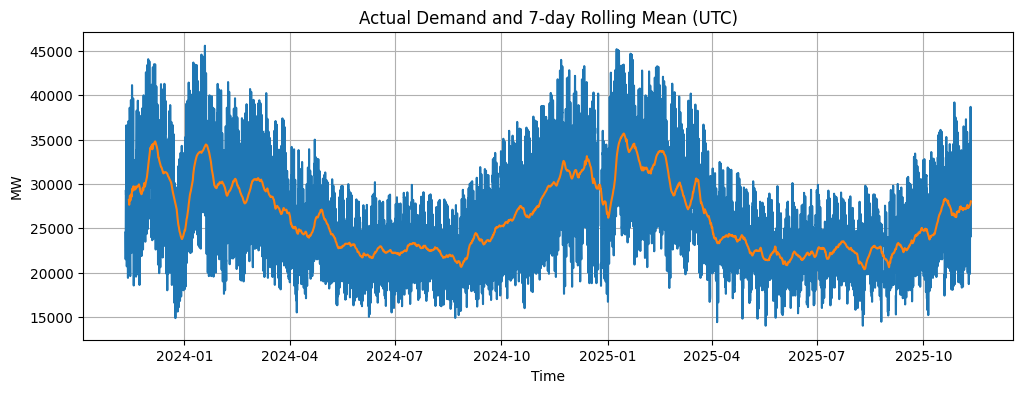

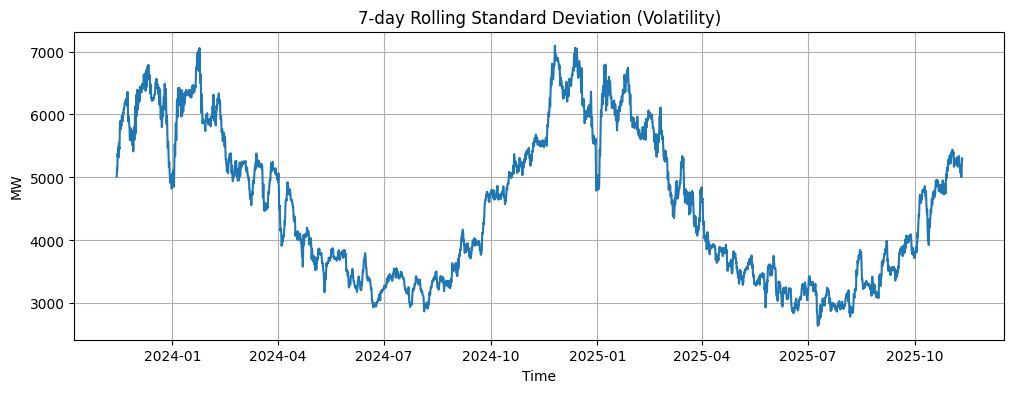

In [7]:

df = df.sort_values("startTime").reset_index(drop=True)
df["roll_mean_7d"] = df["forecast"].rolling(48*7, min_periods=48*3).mean()
df["roll_std_7d"]  = df["forecast"].rolling(48*7, min_periods=48*3).std()

plt.figure()
plt.plot(df["startTime"], df["forecast"])
plt.plot(df["startTime"], df["roll_mean_7d"])
plt.title("Actual Demand and 7-day Rolling Mean (UTC)")
plt.xlabel("Time")
plt.ylabel("MW")
plt.show()

plt.figure()
plt.plot(df["startTime"], df["roll_std_7d"])
plt.title("7-day Rolling Standard Deviation (Volatility)")
plt.xlabel("Time")
plt.ylabel("MW")
plt.show()



## Extremes — Percentiles by month (P5 / P50 / P95)

Gives a sense of **tail behaviour** and **seasonal extremes**.


    month       p05      p50       p95
0       1  25010.00  35092.5  43697.25
1       2  24359.25  32556.5  42102.75
2       3  23153.25  28867.0  38325.50
3       4  21105.05  25861.0  33249.30
4       5  19692.75  23980.0  30508.00
5       6  19822.85  23986.0  29884.65
6       7  19974.25  24725.5  29804.25
7       8  19204.50  23922.0  29914.25
8       9  20695.95  25981.5  32656.00
9      10  21931.00  28819.0  36045.50
10     11  23400.50  32041.5  40973.20
11     12  23374.90  31190.0  41997.00


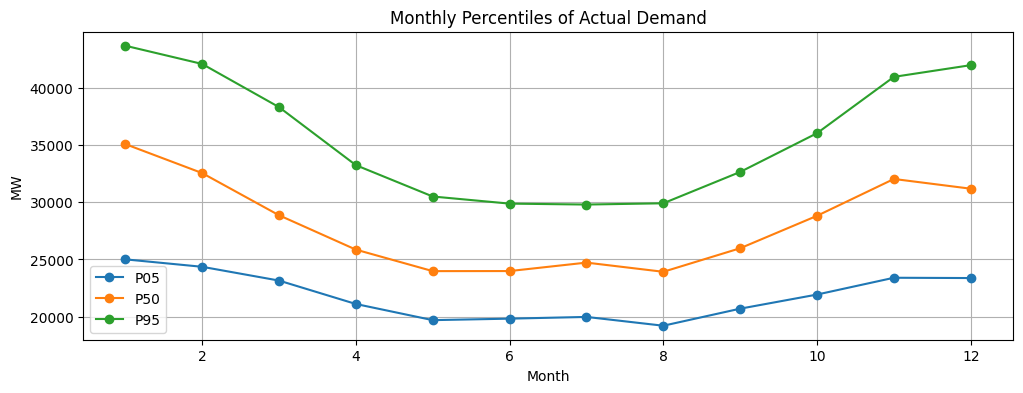

,month,p05,p50,p95
0,1,25010.00,35092.5,43697.25
1,2,24359.25,32556.5,42102.75
2,3,23153.25,28867.0,38325.50
3,4,21105.05,25861.0,33249.30
4,5,19692.75,23980.0,30508.00
5,6,19822.85,23986.0,29884.65
6,7,19974.25,24725.5,29804.25
7,8,19204.50,23922.0,29914.25
8,9,20695.95,25981.5,32656.00
9,10,21931.00,28819.0,36045.50


In [ ]:

from functools import partial
def pct(s, q): 
    return np.percentile(s.dropna(), q)

month_stats = (
    df.groupby("month")["actual"]
      .agg(
          p05=partial(pct, q=5),
          p50=partial(pct, q=50),
          p95=partial(pct, q=95)
      )
      .reset_index()
)
plt.figure()
plt.plot(month_stats["month"], month_stats["p05"], marker="o", label="P05")
plt.plot(month_stats["month"], month_stats["p50"], marker="o", label="P50")
plt.plot(month_stats["month"], month_stats["p95"], marker="o", label="P95")
plt.title("Monthly Percentiles of Actual Demand")
plt.xlabel("Month")
plt.ylabel("MW")
plt.legend()
plt.show()

month_stats


As expected from other results, p95 increases more than p05 in winter
Might be useful to have a boolian winter flag in data


## Anomaly detection — Rolling z-score

Compute `(actual - roll_mean_7d) / roll_std_7d` and flag large deviations.


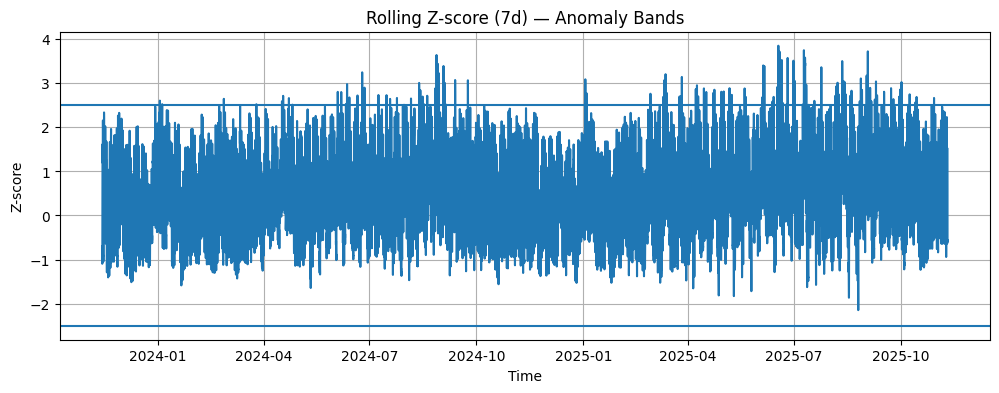

,startTime,actual,zscore_7d
2530,2024-01-02 17:00:00+00:00,39884.0,2.605052
2531,2024-01-02 17:30:00+00:00,39892.0,2.585734
2625,2024-01-04 16:30:00+00:00,42794.0,2.524460
4979,2024-02-22 17:30:00+00:00,40492.0,2.501875
4980,2024-02-22 18:00:00+00:00,40508.0,2.503420
5171,2024-02-26 17:30:00+00:00,41909.0,2.505670
5172,2024-02-26 18:00:00+00:00,42665.0,2.645932
5173,2024-02-26 18:30:00+00:00,42419.0,2.583893
6516,2024-03-25 18:00:00+00:00,40008.0,2.522944
6517,2024-03-25 18:30:00+00:00,39982.0,2.513576


In [8]:

df["zscore_7d"] = (df["actual"] - df["roll_mean_7d"]) / df["roll_std_7d"]
anoms = df[df["zscore_7d"].abs() > 2.5]

plt.figure()
plt.plot(df["startTime"], df["zscore_7d"])
plt.axhline(2.5); plt.axhline(-2.5)
plt.title("Rolling Z-score (7d) — Anomaly Bands")
plt.xlabel("Time")
plt.ylabel("Z-score")
plt.show()

anoms[["startTime","actual","zscore_7d"]].head(20)


Top Z scores for

Jan 2–4

Feb cold spell

March peak

April evening peaks (late daylight/behavioural shifts)

Hot->cold, cold->hot

You can detect anomalies by:
rolling_mean_diff
rolling_std
rolling_zscore (lagged)

These techniques will flag when the model is experienced increased volatility which is when ESO struggles


## Hypothesis testing 




In [15]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, spearmanr

# -------------------------------------------------------------
# Ensure datetime breakdown exists
# -------------------------------------------------------------
df = df.copy()
df["hour"] = df["startTime"].dt.hour
df["dow"] = df["startTime"].dt.dayofweek   # 0=Mon
df["month"] = df["startTime"].dt.month
df["error"] = df["actual"] - df["forecast"]
df["abs_error"] = df["error"].abs()

# Convenience masks
weekday = df["dow"] < 5
weekend = df["dow"] >= 5
winter  = df["month"].isin([12,1,2])
summer  = df["month"].isin([6,7,8])
peak    = df["hour"].between(16,21)
offpeak = ~peak

# -------------------------------------------------------------
# T-TESTS: Group difference tests
# -------------------------------------------------------------
ttests = {}

def add_ttest(name, group1, group2):
    """Run Welch t-test and record result."""
    t, p = ttest_ind(group1, group2, equal_var=False, nan_policy="omit")
    ttests[name] = {"t": t, "p": p}

add_ttest("weekday_vs_weekend (actual)", df.loc[weekday,"actual"], df.loc[weekend,"actual"])
add_ttest("peak_vs_offpeak (actual)", df.loc[peak,"actual"], df.loc[offpeak,"actual"])
add_ttest("winter_vs_summer (actual)", df.loc[winter,"actual"], df.loc[summer,"actual"])

add_ttest("winter_vs_summer_error", df.loc[winter,"error"], df.loc[summer,"error"])
add_ttest("weekday_vs_weekend_error", df.loc[weekday,"error"], df.loc[weekend,"error"])

# -------------------------------------------------------------
# SPEARMAN CORRELATIONS: monotonic drivers
# -------------------------------------------------------------
spearman = {}

def add_spearman(name, x, y):
    rho, p = spearmanr(x, y, nan_policy="omit")
    spearman[name] = {"rho": rho, "p": p}

add_spearman("actual_vs_forecast", df["actual"], df["forecast"])
add_spearman("error_vs_hour", df["hour"], df["error"])
add_spearman("error_vs_month", df["month"], df["error"])
add_spearman("error_vs_abs_hour", abs(df["hour"] - 18), df["error"])   # evening peak proximity
add_spearman("error_vs_load_level", df["actual"], df["error"])         # load-dependent bias

# -------------------------------------------------------------
# Format & display
# -------------------------------------------------------------
tt_df = pd.DataFrame(ttests).T
sp_df = pd.DataFrame(spearman).T

print("📌 Welch t-tests (group mean differences):")
display(tt_df.round(4))

print("\n📌 Spearman rank correlations (monotonic relationships):")
display(sp_df.round(4))

# -------------------------------------------------------------
# Interpretations (human readable)
# -------------------------------------------------------------
print("\n📌 Interpretations:")
for name, res in ttests.items():
    if res["p"] < 0.001:
        signif = "VERY significant"
    elif res["p"] < 0.05:
        signif = "significant"
    else:
        signif = "not significant"

    print(f" - {name}: p={res['p']:.2e} → {signif} difference")

print("\nSpearman interpretations:")
for name, res in spearman.items():
    direction = "positive" if res["rho"] > 0 else "negative"
    print(
        f" - {name}: rho={res['rho']:.3f} ({direction}), p={res['p']:.2e}"
    )


📌 Welch t-tests (group mean differences):


,t,p
weekday_vs_weekend (actual),50.3023,0.0000
peak_vs_offpeak (actual),85.1970,0.0000
winter_vs_summer (actual),119.0563,0.0000
winter_vs_summer_error,-1.0943,0.2738
weekday_vs_weekend_error,6.1353,0.0000



📌 Spearman rank correlations (monotonic relationships):


,rho,p
actual_vs_forecast,0.9660,0.0
error_vs_hour,-0.2154,0.0
error_vs_month,0.0357,0.0
error_vs_abs_hour,0.2367,0.0
error_vs_load_level,-0.0767,0.0



📌 Interpretations:
 - weekday_vs_weekend (actual): p=0.00e+00 → VERY significant difference
 - peak_vs_offpeak (actual): p=0.00e+00 → VERY significant difference
 - winter_vs_summer (actual): p=0.00e+00 → VERY significant difference
 - winter_vs_summer_error: p=2.74e-01 → not significant difference
 - weekday_vs_weekend_error: p=8.67e-10 → VERY significant difference

Spearman interpretations:
 - actual_vs_forecast: rho=0.966 (positive), p=0.00e+00
 - error_vs_hour: rho=-0.215 (negative), p=0.00e+00
 - error_vs_month: rho=0.036 (positive), p=4.63e-11
 - error_vs_abs_hour: rho=0.237 (positive), p=0.00e+00
 - error_vs_load_level: rho=-0.077 (negative), p=1.98e-45


weak spearman and t for seasonality difference

abs hour is a test around the peak. Here, Forecast error increases the further away you are from the daily peak.
Morning ramp, overnight baseload, midday trough → influenced by behaviour, solar, industry → harder to model

| Behaviour                                           | Evidence                  | Model     |
| --------------------------------------------------- | ------------------------- | -------------------------------- |
| Underpredicts consistently by ~7–8% (not seasonaly)             | descriptive stats         | Add intercept + slope correction |
| Over-volatile                                   | std higher than actual    | Smooth or regularise forecast (ridge regression or rolling mean)    |
| Errors vary strongly by hour                    | ρ = -0.215, ρ = 0.237     | Add hour-of-day features, hour sin/cos, is peak flag         |
| Errors vary by weekday/weekend                  | highly significant t-test | Add weekend flag                 |
| Seasonality exists but forecast handles it well | weak ρ vs month           | Seasonal features optional       |
| Extreme anomalies cluster during cold spells    | rolling z                 | Add volatility regime features (lagged z-score, rolling volatility, anomaly flags, recent-trend deviation)  |
| Load level negatively correlated with error     | ρ = -0.077                | Slope correction helps           |


Build a model that takes the prediction from ESO and makes it better
Competing with actual_vs_forecast: **rho=0.966**,
I do not expect much shapre improvements but I can improve on errors
